# Sanity Check Training

In [1]:
0

0

In [2]:
import copy
import gc
import logging
import os
import sys
import warnings

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import tqdm
import torch

sc.settings.verbosity = 3

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
adata_file_path = (
    "/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/"
    "dataset_subset_sample_status_1.h5ad"
)
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
metadata_of_interest = "sample_status"

In [5]:
torch.cuda.is_available()

False

## Vizualization Without Training

In [6]:
adata = ad.read_h5ad(adata_file_path)
display(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

AnnData object with n_obs × n_vars = 11279 × 4096
    obs: 'handle_anndata', 'study', 'sample_ID', 'organ', 'age', 'cell_type', 'lane_ID', 'author_batch', 'institute', 'study_PI', 'doi', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'anatomical_region', 'anatomical_region_level_2', 'sex', 'sex_inferred', 'subject_type', 'sample_status', 'sample_cultured', 'protocol_tissue_dissociation', 'cell_enrichment', 'library_platform', 'strand_sequence', 'sequencing_platform', 'reads_processing', 'biological_unit', 'reference_genome', 'reference_genome_ensembl_release', 'concatenated_integration_covariates'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'highly_variable', 'hvg', 'log1p', 'unification'

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


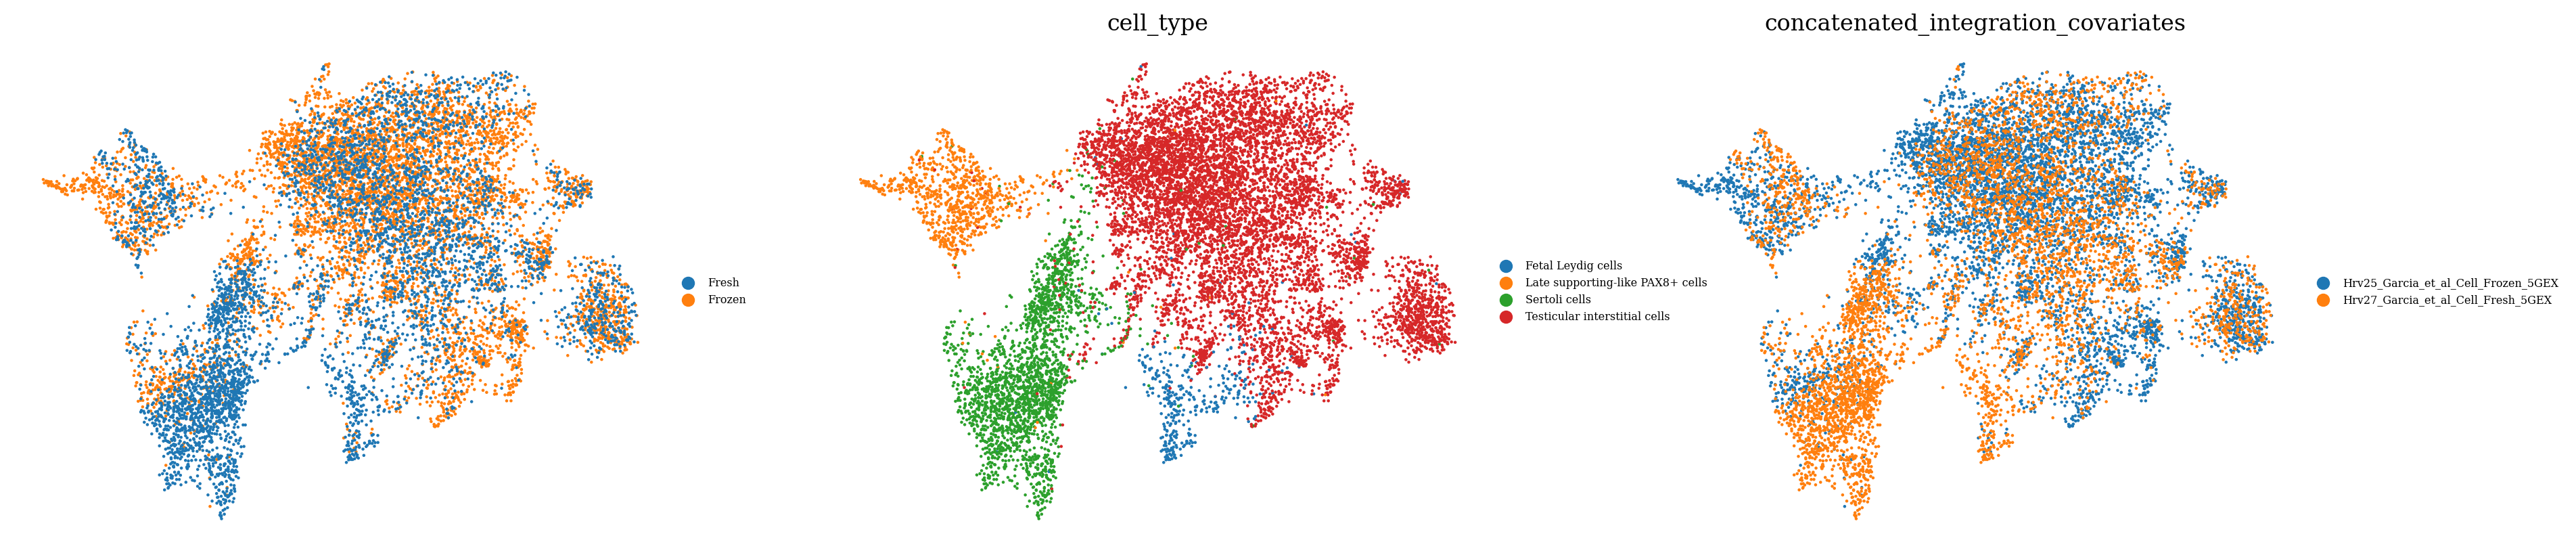

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata, 
        color=[metadata_of_interest, "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )
del adata
gc.collect();

## Training

In [8]:
adata = ad.read_h5ad(adata_file_path)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scvi.model.SCVI.setup_anndata(adata, layer=None, batch_key="concatenated_integration_covariates")
    vae = scvi.model.SCVI(
        adata, 
        n_hidden = 512,
        n_layers=3, 
        n_latent=20, 
        gene_likelihood="nb",
        dropout_rate = 0.1
    )
    vae.train(max_epochs=200)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|███████████████████████████████████████████████████████████| 200/200 [1:04:07<00:00, 14.05s/it, v_num=1, train_loss_step=170, train_loss_epoch=174]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████| 200/200 [1:04:08<00:00, 19.24s/it, v_num=1, train_loss_step=170, train_loss_epoch=174]


In [10]:
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, n_neighbors = 30, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


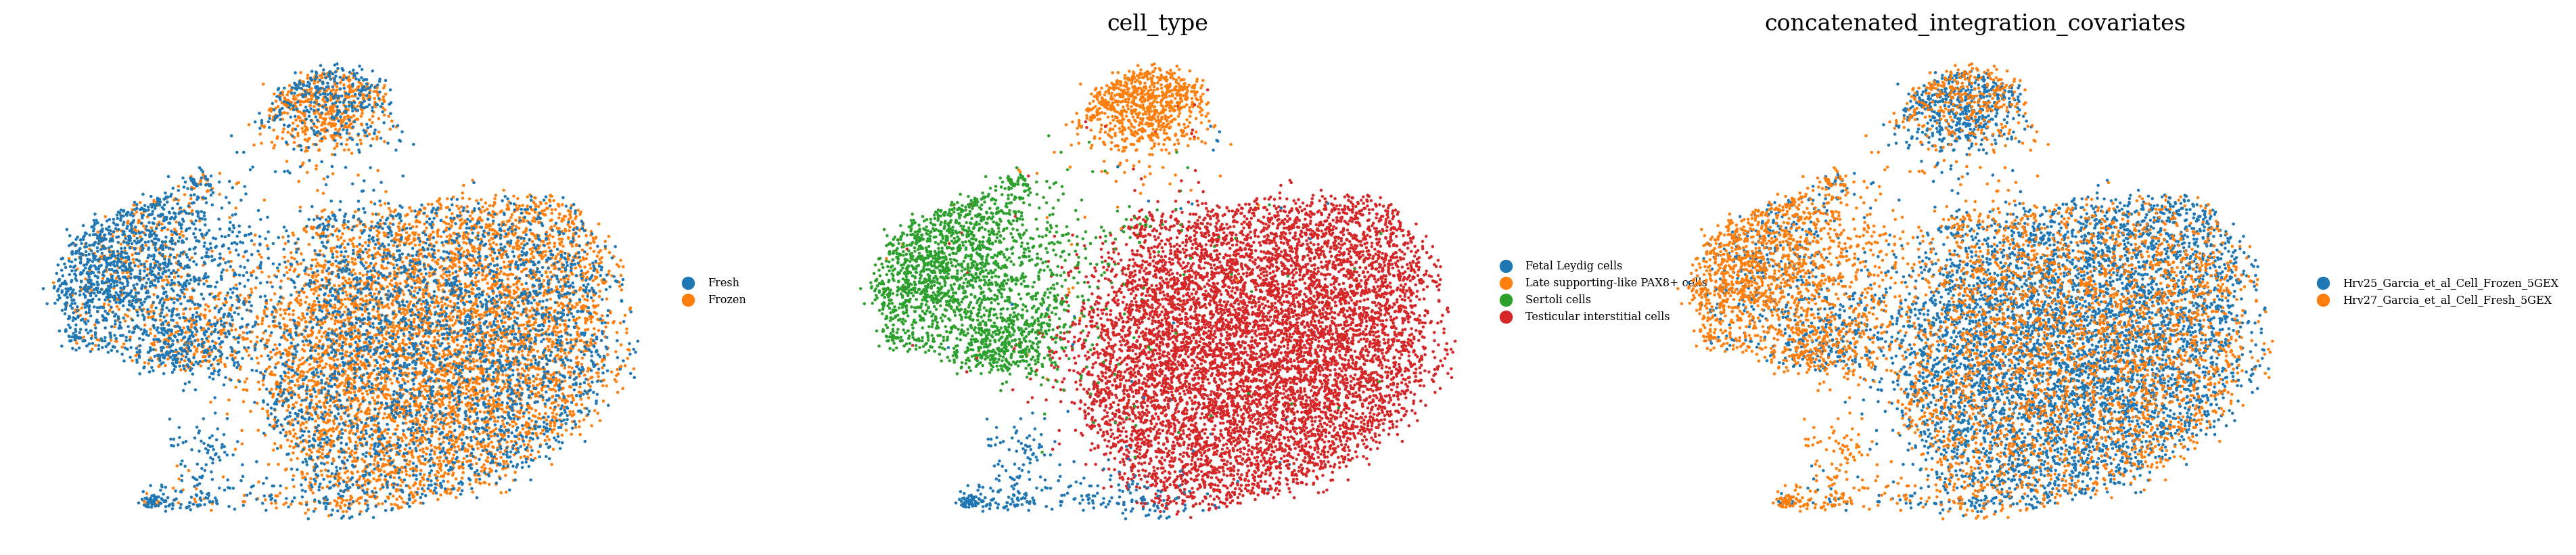

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        adata, 
        color=[metadata_of_interest, "cell_type", "concatenated_integration_covariates"], 
        ncols=3,
        frameon=False,
        title="",
        legend_fontsize="xx-small"
    )